In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings 
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("AirPassengers.csv")  # 12 years data 

In [3]:
df.head()

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121


In [4]:
df.tail()

,Month,Passengers
139,15-08-1960,606
140,15-09-1960,508
141,15-10-1960,461
142,15-11-1960,390
143,15-12-1960,432


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
df=df.set_index("Month")
df.head()

,Passengers
Month,
15-01-1949,112
15-02-1949,118
15-03-1949,132
15-04-1949,129
15-05-1949,121


### Visualize the TimeSeries

**check for trend , seasonality or random pattern**

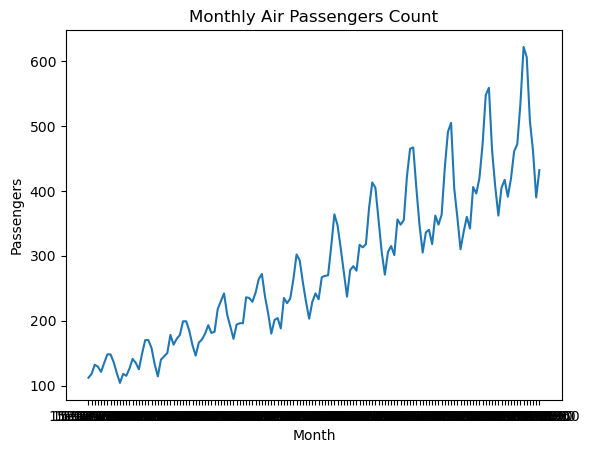

In [7]:
# # Visualizing the original time series data (Passengers over months)

sns.lineplot(x=df.index,y=df['Passengers'])
plt.title("Monthly Air Passengers Count")
plt.show()

### check for stationality 

**Method-1: Rolling Statistics**

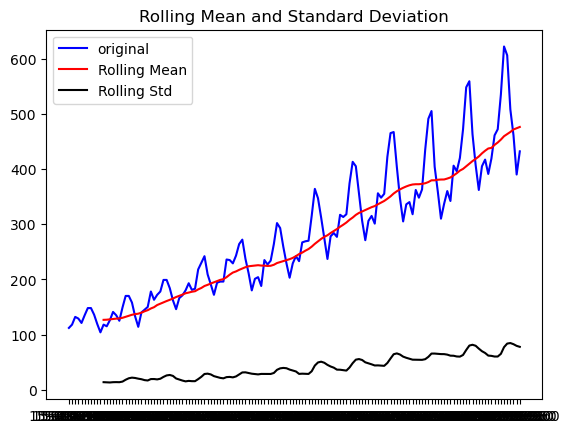

In [8]:
# Determining rolling mean and standard deviation to observe trends over time
rolmean=df["Passengers"].rolling(window=12).mean()
rolstd=df["Passengers"].rolling(window=12).std()

# plot rolling statistics 
orig=plt.plot(df["Passengers"],color='blue',label='original')
mean=plt.plot(rolmean,color='red',label='Rolling Mean')
std=plt.plot(rolstd,color='black',label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

**Method-2: Augumented Dicky Fuller Test**

- for the ADF Test
  - H0 : data is non stationary 
  - H1 : data is stationary
- Based om p-value , we will accept or reject H0 (if p-value < 5% ,reject null hypothesis)

In [9]:
# Importing ADF test to check stationarity
from statsmodels.tsa.stattools import adfuller

# Performing the ADF test on the original data
adfuller_result=adfuller(df["Passengers"])
adfuller_result

(0.8153688792060547,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [10]:
print("p-value :",adfuller_result[1])

p-value : 0.9918802434376411


**The time series is not stationary**

### Now Convert to Stationary 

**Differencing**

In [11]:
# Making the series stationary by differencing (subtracting previous values)
diff=df["Passengers"]-df["Passengers"].shift(2)
diff.dropna(inplace=True)

# Applying ADF Test
adfuller_result=adfuller(diff)
print('p-value od ADF test :',adfuller_result[1])

p-value od ADF test : 0.03862975767698775


**Now the data is stationary**

### Plot ACF/PACF and find p,d,q parameters

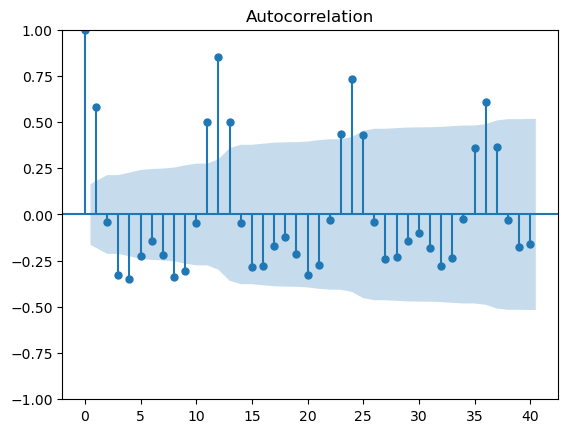

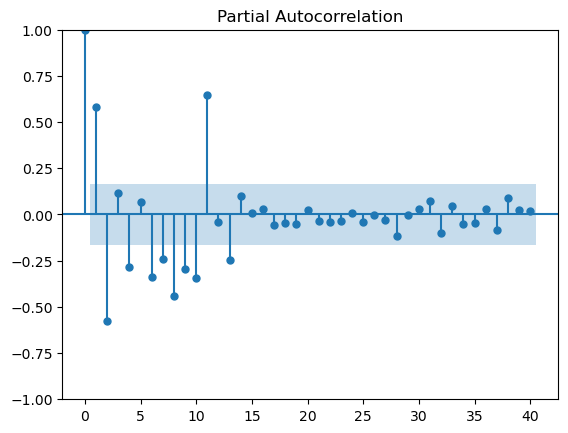

In [12]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig=sm.graphics.tsa.plot_acf(diff,lags=40)
fig=sm.graphics.tsa.plot_pacf(diff,lags=40)

**From ACF curve , optimal value of q in the ARIMA model must be 1**

**From PACF curve , optimal value of p in the ARIMA model is 1**

In [13]:
df.shape

(144, 1)

### Train Test Split

**split the data into train(80%) and test(20%)**

- for the series data we have use first 80% of records for training and next 20% of records for testing 
- here 80% = 0.8*142 = 114 records , so first 114 records we have to use for training 

**Note: We should not apply train test split function , because it divides the data randomly**

In [14]:
# Splitting the differenced data into training and testing sets
y_train=diff[:114]
y_test=diff[114:]

### Build ARIMA Model

**ARIMA Model is build by using p,d,q values**

- p is AR value (determine from PACF plot)
- d is integration
- q is MA value (determined from ACF plot)

**Modelling**

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(diff,order=(1,2,1))
ARIMA=model.fit()

C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
print(y_test.shape)
print(y_train.shape)


(28,)
(114,)


**Prediction**

In [17]:
ypred_test=ARIMA.predict(start=y_test.index[0],end=y_test.index[-1])
ypred_train=ARIMA.predict(start=y_train.index[0],end=y_train.index[-1])


**Evaluation**

In [18]:
from sklearn.metrics import r2_score
print("Train r2 :",r2_score(ypred_train,y_train))
print("Test r2 :",r2_score(ypred_test,y_test))

Train r2 : 0.3402248545897033
Test r2 : 0.4239665879089193


- **Here ARIMA Model is not performing well , because there is seasonality in the given dataset**

### SARIMA   Model 

**Whenever there is seasonality in given dataset , apply SARIMAX**

**SARIMAX Model is build by using p,d,q,s values**

- p is AR value (determine from PACF plot)
- d is integration
- q is MA value (determined from ACF plot)
- s is seasonality value

**Modelling**

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(diff,seasonal_order=(1,2,1,12))
SARIMAX=model.fit()

C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**Prediction**

In [20]:
ypred_test=SARIMAX.predict(start=y_test.index[0],end=y_test.index[-1])
ypred_train=SARIMAX.predict(start=y_train.index[0],end=y_train.index[-1])


**Evaluation**

In [21]:
from sklearn.metrics import r2_score
print("Train r2 of Sarima model:",r2_score(ypred_train,y_train))
print("Test r2 of Sarima model:",r2_score(ypred_test,y_test))

Train r2 of Sarima model: 0.9053232875695264
Test r2 of Sarima model: 0.9540348278628887
